
=== Mexico - ORGC Dataset ===

Model: Support Vector Regressor
R² Score: -466.4600, MAE: 15.1516, MSE: 467.4600, RMSE: 21.6208

Model: Linear Regression
R² Score: -479.8322, MAE: 15.4486, MSE: 480.8322, RMSE: 21.9279

Model: Gradient Boosting Regressor
R² Score: -476.2085, MAE: 15.0614, MSE: 477.2085, RMSE: 21.8451

Model: K-Nearest Neighbors Regressor
R² Score: -473.5159, MAE: 15.1536, MSE: 474.5159, RMSE: 21.7834

Model: Random Forest Regressor
R² Score: -476.8624, MAE: 15.0657, MSE: 477.8624, RMSE: 21.8601


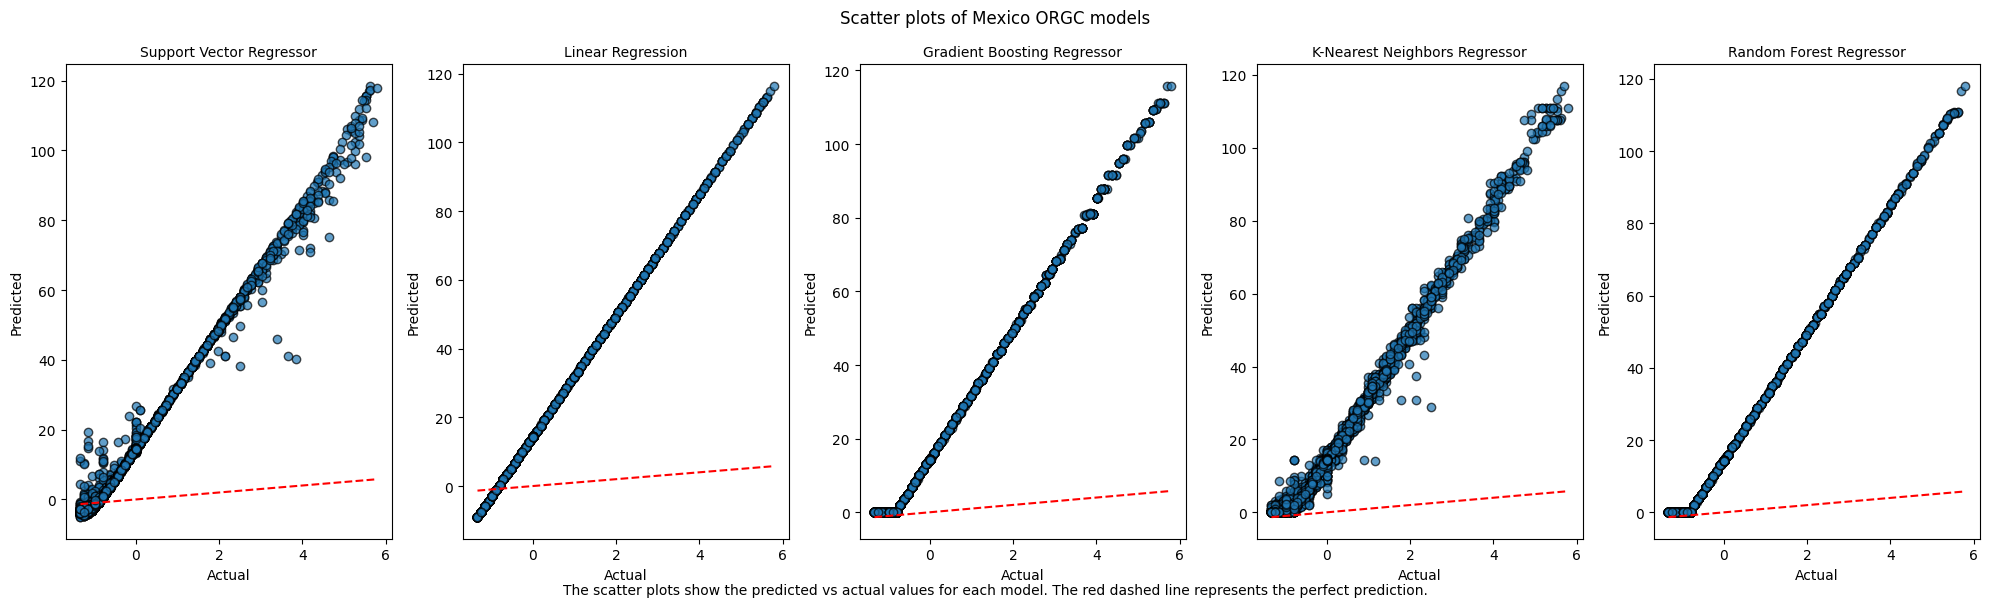


=== Mexico - TCEQ Dataset ===

Model: Support Vector Regressor
R² Score: -1525.2101, MAE: 30.3294, MSE: 1526.2101, RMSE: 39.0667

Model: Linear Regression
R² Score: -5891.8456, MAE: 66.5241, MSE: 5892.8456, RMSE: 76.7649

Model: Gradient Boosting Regressor
R² Score: -5873.9513, MAE: 56.7156, MSE: 5874.9513, RMSE: 76.6482

Model: K-Nearest Neighbors Regressor
R² Score: -8739.5276, MAE: 56.1765, MSE: 8740.5276, RMSE: 93.4908

Model: Random Forest Regressor
R² Score: -5462.5992, MAE: 53.5373, MSE: 5463.5992, RMSE: 73.9162


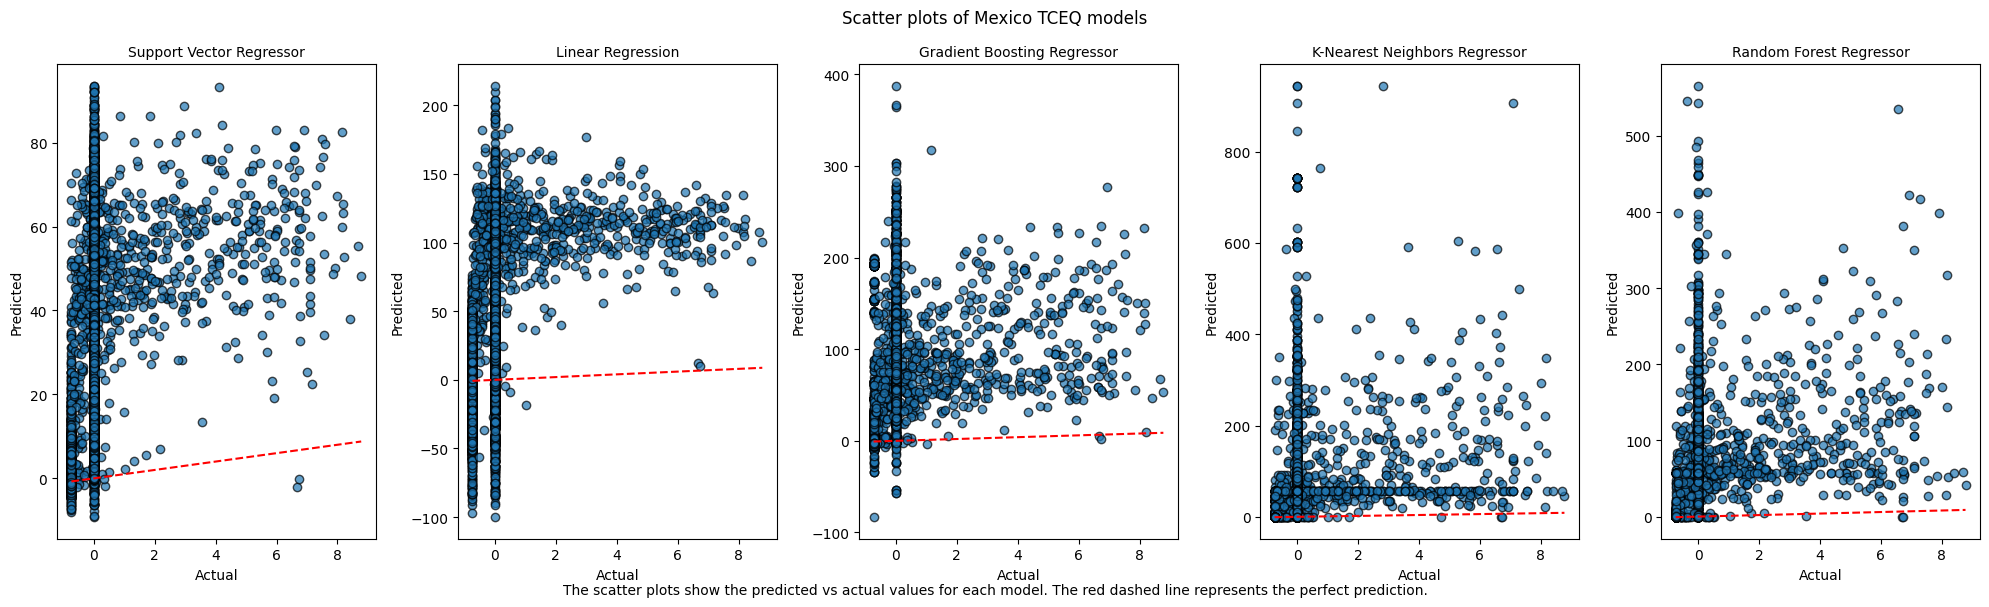


=== Guatemala - ORGC Dataset ===

Model: Support Vector Regressor
R² Score: -404.1316, MAE: 15.5839, MSE: 405.1316, RMSE: 20.1279

Model: Linear Regression
R² Score: -479.8322, MAE: 15.6096, MSE: 480.8322, RMSE: 21.9279

Model: Gradient Boosting Regressor
R² Score: -473.6218, MAE: 15.1209, MSE: 474.6218, RMSE: 21.7858

Model: K-Nearest Neighbors Regressor
R² Score: -483.2928, MAE: 15.1617, MSE: 484.2928, RMSE: 22.0067

Model: Random Forest Regressor
R² Score: -474.8457, MAE: 15.1117, MSE: 475.8457, RMSE: 21.8139


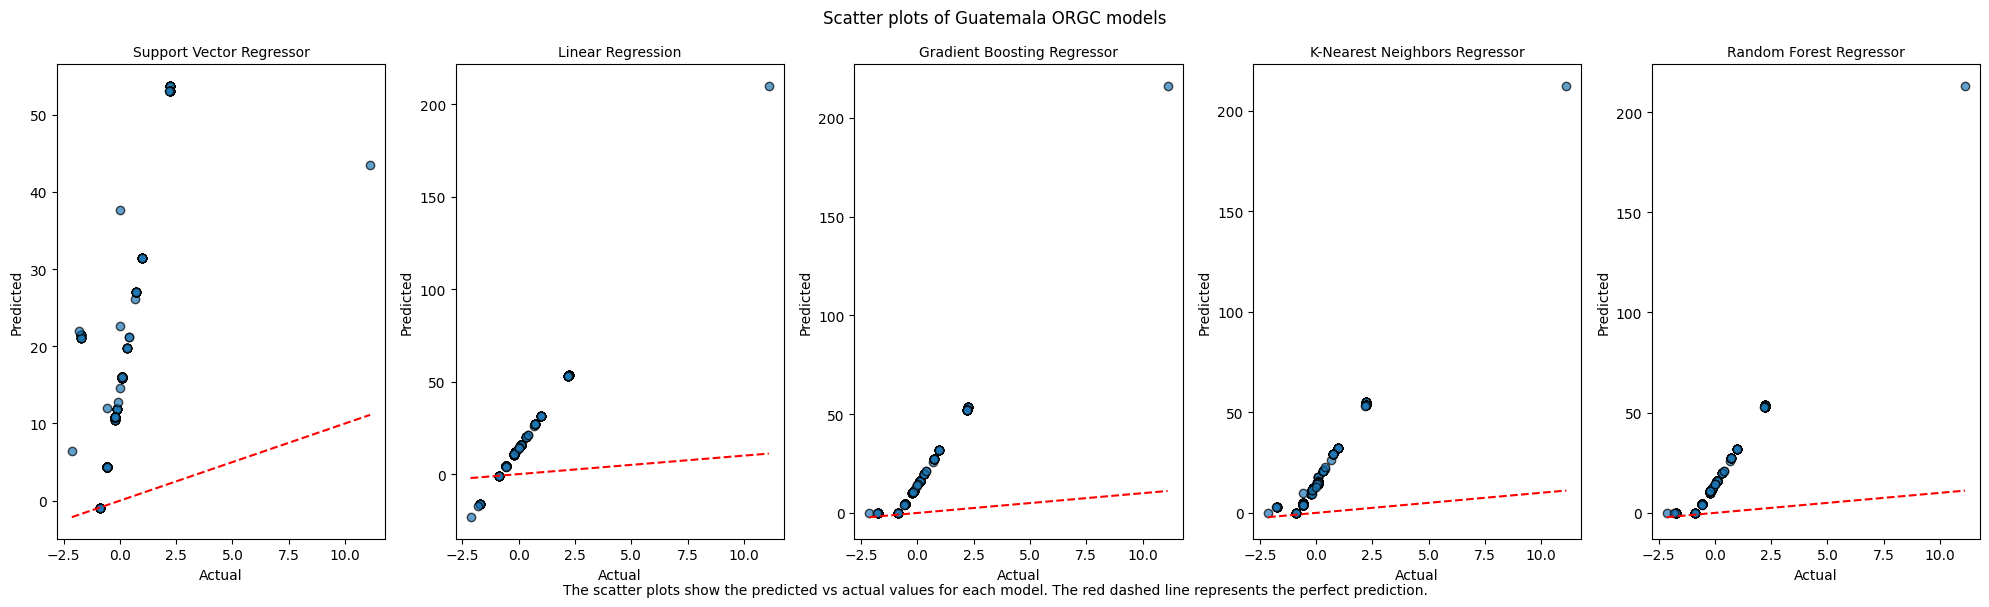


=== Guatemala - TCEQ Dataset ===

Model: Support Vector Regressor
R² Score: 0.0000, MAE: 32.0556, MSE: 1919.0358, RMSE: 43.8068

Model: Linear Regression
R² Score: 0.0000, MAE: 69.1449, MSE: 6159.7877, RMSE: 78.4843

Model: Gradient Boosting Regressor
R² Score: 0.0000, MAE: 42.7412, MSE: 4286.5878, RMSE: 65.4720

Model: K-Nearest Neighbors Regressor
R² Score: 0.0000, MAE: 54.1712, MSE: 10303.8858, RMSE: 101.5081

Model: Random Forest Regressor
R² Score: 0.0000, MAE: 18.0345, MSE: 897.3189, RMSE: 29.9553


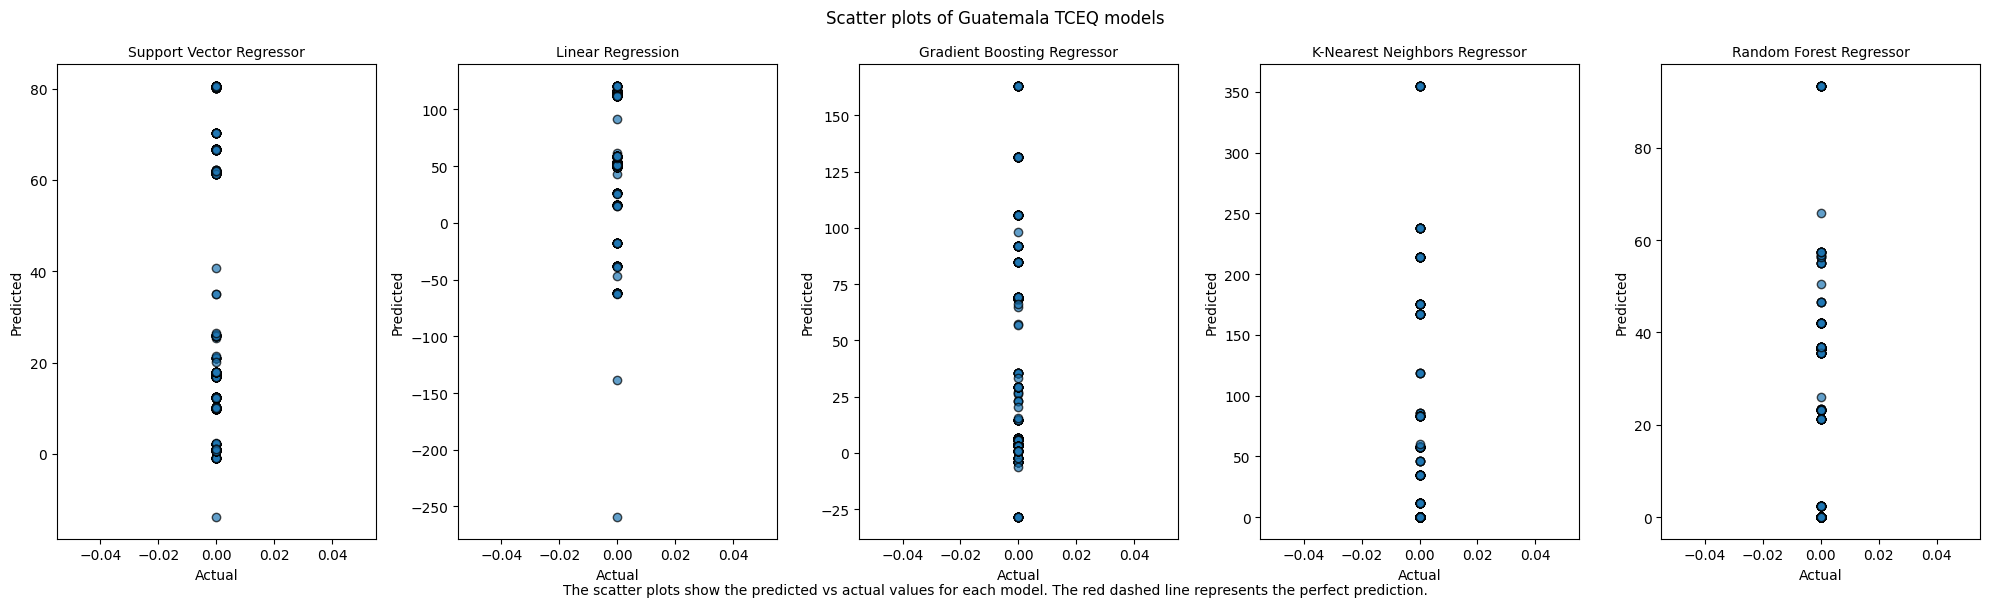

In [4]:
import joblib
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import datetime

def load_dataset(country_name):
    # get current date
    current_date = datetime.datetime.now().strftime("%Y%m%d")
    dataset_path = f"../outputs/{current_date}/{country_name}_wosis/{country_name}_wosis_merged.csv"

    # load the dataset
    dataset = pd.read_csv(dataset_path)

    # introduce new columns
    # create organic matter
    dataset['OM'] = dataset.apply(lambda row: 1.724 * row['orgc'].astype('float'), axis=1)
    # create bulk density
    dataset['BD'] = dataset.apply(lambda row: 1.62-0.06 * row['OM'].astype('float'), axis=1)
    # create SOC_th
    dataset['SOC_th'] = dataset.apply(lambda row: (row['orgc'].astype('float')/1000) * 30 , axis=1)
    # create silt_plus_clay
    dataset['silt_plus_clay'] = dataset.apply(lambda row: row['silt'] + row['clay'] , axis=1)

    # drop silt and clay
    dataset = dataset.drop(columns=['silt', 'clay', 'lower_depth', 'upper_depth', 'longitude', 'latitude'])

    # replace NaN with mean
    dataset = dataset.fillna(dataset.mean())

    # split dataset into orgc and tceq
    orgc_df = dataset.drop(columns=['tceq']).copy()
    tceq_df = dataset.drop(columns=['orgc']).copy()

    # Standard scaling
    scaler = StandardScaler()
    orgc_df = pd.DataFrame(scaler.fit_transform(orgc_df), columns=orgc_df.columns)
    tceq_df = pd.DataFrame(scaler.fit_transform(tceq_df), columns=tceq_df.columns)

    orgc_df.to_csv(f"../outputs/{current_date}/{country_name}_wosis/{country_name}_wosis_orgc_scaled.csv", index=False)
    tceq_df.to_csv(f"../outputs/{current_date}/{country_name}_wosis/{country_name}_wosis_tceq_scaled.csv", index=False)

    return {'ORGC': orgc_df, 'TCEQ': tceq_df}

# models
models = {
    'Random Forest Regressor',
    'Gradient Boosting Regressor',
    'Linear Regression',
    'Support Vector Regressor',
    'K-Nearest Neighbors Regressor',
}

datasets = ['ORGC', 'TCEQ']
countries = ["Mexico", "Guatemala"]

for country_name in countries:
    datasets = load_dataset(country_name)

    for dataset_name, df in datasets.items():
        print(f"\n=== {country_name} - {dataset_name} Dataset ===")

         # Prepare features and target
        target_col = 'orgc' if dataset_name == 'ORGC' else 'tceq'
        feature_cols = [col for col in df.columns if col not in [target_col]]
        
        X_new = df[feature_cols]
        y_new = df[target_col]

        fig, axes = plt.subplots(1, len(models), figsize=(20, 6))
        for idx, model_name in enumerate(models):
            model_path = f'../models/{dataset_name}_{model_name}.pkl'
            print(f"\nModel: {model_name}")

            try:
                model = joblib.load(model_path)

                # Make predictions
                y_pred = model.predict(X_new)

                # Evaluate the model
                r2 = r2_score(y_new, y_pred)
                mae = mean_absolute_error(y_new, y_pred)
                mse = mean_squared_error(y_new, y_pred)
                rmse = np.sqrt(mean_squared_error(y_new, y_pred))

                # Print metrics
                metrics = f"R² Score: {r2:.4f}, MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}"
                print(metrics)

                # Scatter plot of predicted vs actual
                axes[idx].scatter(y_new, y_pred, alpha=0.7, edgecolors='k')
                axes[idx].plot([y_new.min(), y_new.max()], [y_new.min(), y_new.max()], 'r--')
                axes[idx].set_title(f'{model_name}', fontsize=10)
                axes[idx].set_xlabel('Actual')
                axes[idx].set_ylabel('Predicted')
                
            except FileNotFoundError:
                print(f"Model {model_path} not found")
                continue
                
        plt.suptitle(f'Scatter plots of {country_name} {dataset_name} models')
        plt.tight_layout()
        plt.figtext(0.5, 0.005,
                    'The scatter plots show the predicted vs actual values for each model. '
                    'The red dashed line represents the perfect prediction.', 
                    ha='center', fontsize=10)
        plt.show()